## Title: Data Cleaning and Feature Engineering
- Author: Maha Siraj
- November 2, 2017


### Summary:
- Cleaning data
 - check duplicates and missing values (**Verify data quality**)
 - omitted customer_id from further analysis
 - convert categorical variables to numerical variables.
 


- Data Transformation
 - used to stabilize variance, make the continuous variables more normal-like 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import sklearn.metrics as skl_metrics
import sklearn.linear_model as skl_lm
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor 
import nltk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, precision_score,  roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

blue = sns.color_palette('Blues')[-2] 
color = sns.color_palette() 
sns.set_style('darkgrid') 
#pd.set_option('display.float_foimport nltk
blue = sns.color_palette('Blues')[-2]
color = sns.color_palette() 
sns.set_style('darkgrid') 
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import nltk


In [15]:
data=pd.read_csv('Clothing_Store.csv')
data.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9955600066402,1001,208,2,368.460,0,184.230,11,0.180,0.000,...,N,0,5,0,0.000,31.810,111.000,10,0.000,0
1,9955600073501,1028,6,4,258.000,1,64.500,11,0.260,0.160,...,Y,0,4,2,50.000,32.720,43.500,10,0.030,1
2,9955600076313,1056,327,2,77.000,0,38.500,11,1.000,0.000,...,N,0,4,0,0.000,100.000,68.600,16,0.000,0
3,9955600078045,1118,66,8,846.060,1,105.750,11,0.380,0.000,...,Y,0,9,6,66.670,23.270,26.960,10,0.000,0
4,9955600078517,1107,49,1,87.440,0,87.440,11,0.200,0.200,...,Y,0,0,0,0.000,28.520,24.500,20,0.000,0


## Step 1: Clean data

In [16]:
# change one categorical variable to binary
data['VALPHON']=(data['VALPHON']=='Y').astype(int)  #Yes==1
data=data.loc[:, data.dtypes!='object'] # discards the columns that are not numerical

In [17]:
idsUnique = len(set(data.HHKEY))  
idsTotal = data.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate for " + str(idsTotal) + " total customers")

del data['HHKEY']

There are 0 duplicate for 21740 total customers


In [18]:
state=460244129  # use yiran's id
train = data.sample(frac=0.6, random_state=state)
test = data[data.index.isin(train.index)==False].copy()
y_train=train["RESP"] 
y_test=test["RESP"]

In [19]:
# to apply bayes rule, we separate response y0 and y1. and check univariate dist separately. 
train_y0=train[train['RESP']==0.0]
train_y1=train[train['RESP']==1.0]
train_y0.head()  

,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,PKNIT_DRES,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
8699,44012,280,1,74.700,1,74.700,11,0.000,0.000,0.000,...,1,0,0,0,0.000,88.670,280.000,10,0.000,0
2376,17036,216,2,5.000,0,2.500,11,1.000,0.000,0.000,...,1,0,0,0,0.000,156.250,161.500,8,3.000,0
15843,64132,34,2,955.090,1,477.540,11,0.000,0.000,0.000,...,1,0,1,1,100.000,28.640,20.000,24,0.000,0
6737,33626,270,1,157.490,0,157.490,11,0.370,0.000,0.000,...,0,0,2,0,0.000,40.100,135.000,6,0.000,0
8287,41048,267,1,287.000,0,287.000,16,0.000,0.000,0.270,...,0,0,1,0,0.000,57.110,133.500,16,0.000,0


if our prediction is no response for all customers. the test error is 0.177. we should use our model to minimise it as much as possible

## Step 2: Transformations to Achieve Normality or Symmetry (continuous variable)

#### Reason:
Many data mining methods and models, such as principal components analysis and logistic regression, function best when the variables are normally distributed or, failing that, at least symmetric. Thus, we therefore apply transformations to all of the numerical variables that require it, to induce approximate normality or symmetry.


In [45]:
# firstly we define a function to simply the following code process
def distribution_histor_Q_Qplot(predictor, data1, data2, data3):
    fig, ax= plt.subplots(2,3, figsize=(18,10))
    sns.distplot(data1[predictor] , fit=norm,ax=ax[0,0]);(mu, sigma) = norm.fit(data1[predictor])
    ax[0,0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    ax[0,0].set(title='Historgam of '+predictor, xlabel=predictor,ylabel='Frequency')
    
    pp = sm.ProbPlot(data1[predictor], fit=True)
    qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,0])
    a=ax[1,0].get_xlim()[0]
    b=ax[1,0].get_xlim()[1]
    ax[1,0].plot([a,b],[a,b], color='black', alpha=0.6)
    ax[1,0].set_xlim(-6,6)
    ax[1,0].set_ylim(-6,6)
    ax[1,0].set_title('Normal Q-Q plot for the '+predictor)
    
    sns.distplot(data2[predictor] , fit=norm,ax=ax[0,1]);
    (mu, sigma) = norm.fit(data1[predictor])
    ax[0,1].set(title='Historgam of '+predictor+' when no customer response', xlabel=predictor,ylabel='Frequency')
    ax[0,1].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    pp = sm.ProbPlot(data2[predictor], fit=True)
    qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,1])
    a=ax[1,1].get_xlim()[0]
    b=ax[1,1].get_xlim()[1]
    ax[1,1].plot([a,b],[a,b], color='black', alpha=0.6)
    ax[1,1].set_xlim(-6,6)
    ax[1,1].set_ylim(-6,6)
    ax[1,1].set_title('Normal Q-Q plot for the '+predictor+' when no customer response')
    
    sns.distplot(data3[predictor] , fit=norm,ax=ax[0,2]);
    (mu, sigma) = norm.fit(data3[predictor])
    ax[0,2].set(title='Historgam of '+predictor+' when customer response', xlabel=predictor,ylabel='Frequency')
    ax[0,2].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    pp = sm.ProbPlot(data3[predictor], fit=True)
    qq = pp.qqplot(color=sns.color_palette('Blues')[-1], alpha=0.8, ax=ax[1,2])
    a=ax[1,2].get_xlim()[0]
    b=ax[1,2].get_xlim()[1]
    ax[1,2].plot([a,b],[a,b], color='black', alpha=0.6)
    ax[1,2].set_xlim(-6,6)
    ax[1,2].set_ylim(-6,6)
    ax[1,2].set_title('Normal Q-Q plot for the '+predictor+' when customer response')
    
    plt.show()

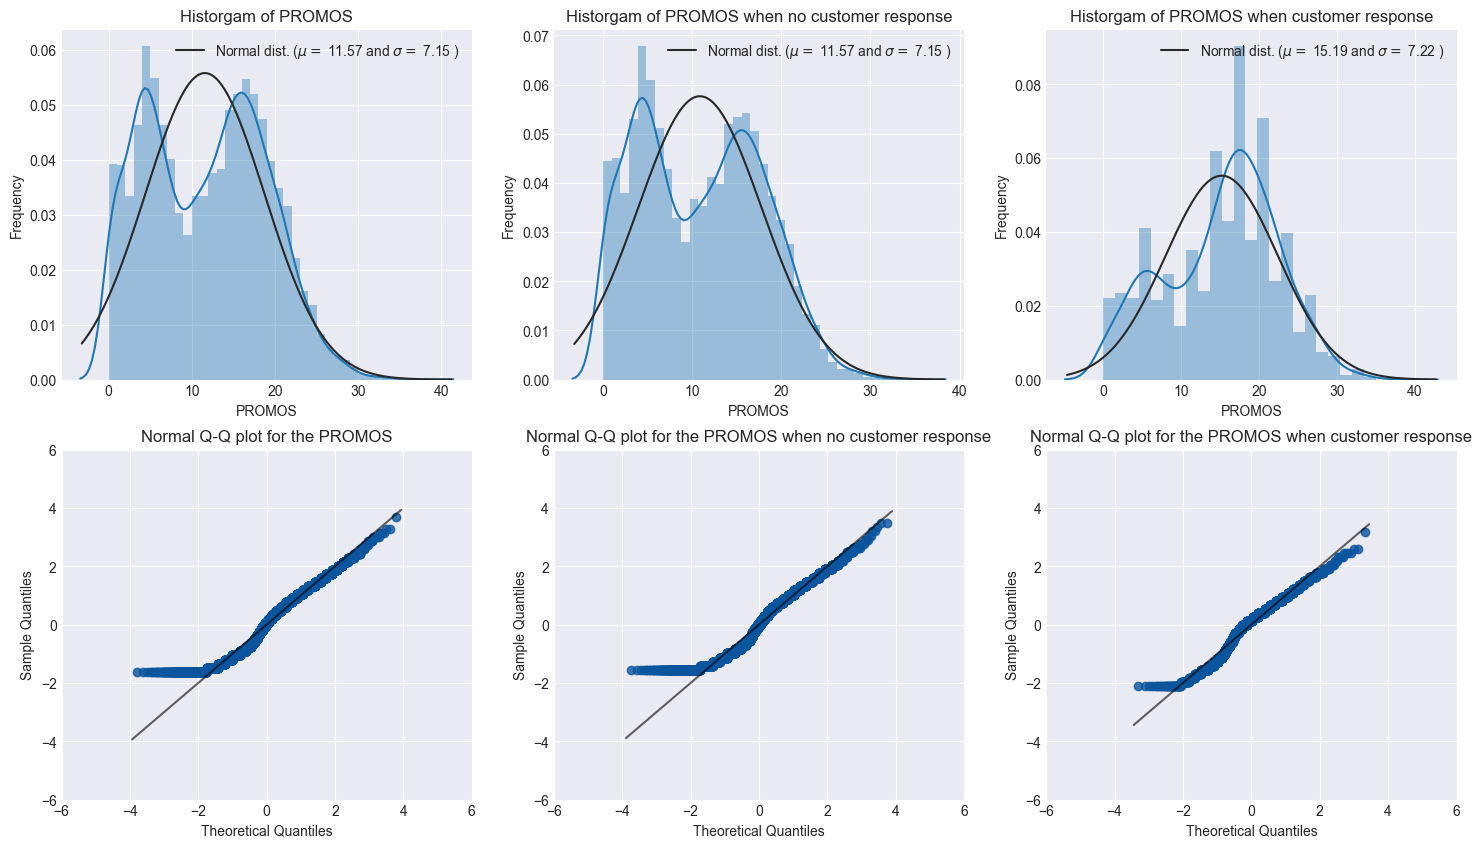

In [46]:
distribution_histor_Q_Qplot('PROMOS', train, train_y0, train_y1)    

In [49]:
def bonxcox_transf(data):
    y, lmbda=stats.boxcox(data)
    output=((data**lmbda - 1) / lmbda)
    print("The lmbda is: "+str(lmbda))
    del data # must delete old one, and remember to mention it in report
    return output 

In [50]:
def log_transf(data):
    output=np.log(data)
    return output

### Skewed features
Most of the numeric fields are right-skewed

In [51]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(60)


Skew in numerical features: 



,Skew
PERCRET,35.896
AMSPEND,31.142
CCSPEND,12.570
AXSPEND,11.990
PJEWELRY,11.235
PLEGWEAR,10.498
PSSPEND,9.749
MON,8.197
SMONSPEND,7.616
STYLES,7.525


For example, the following plots for percret(Percent of returns) amspend (Amount spent at each of four different franchises (four variables).)

## MON

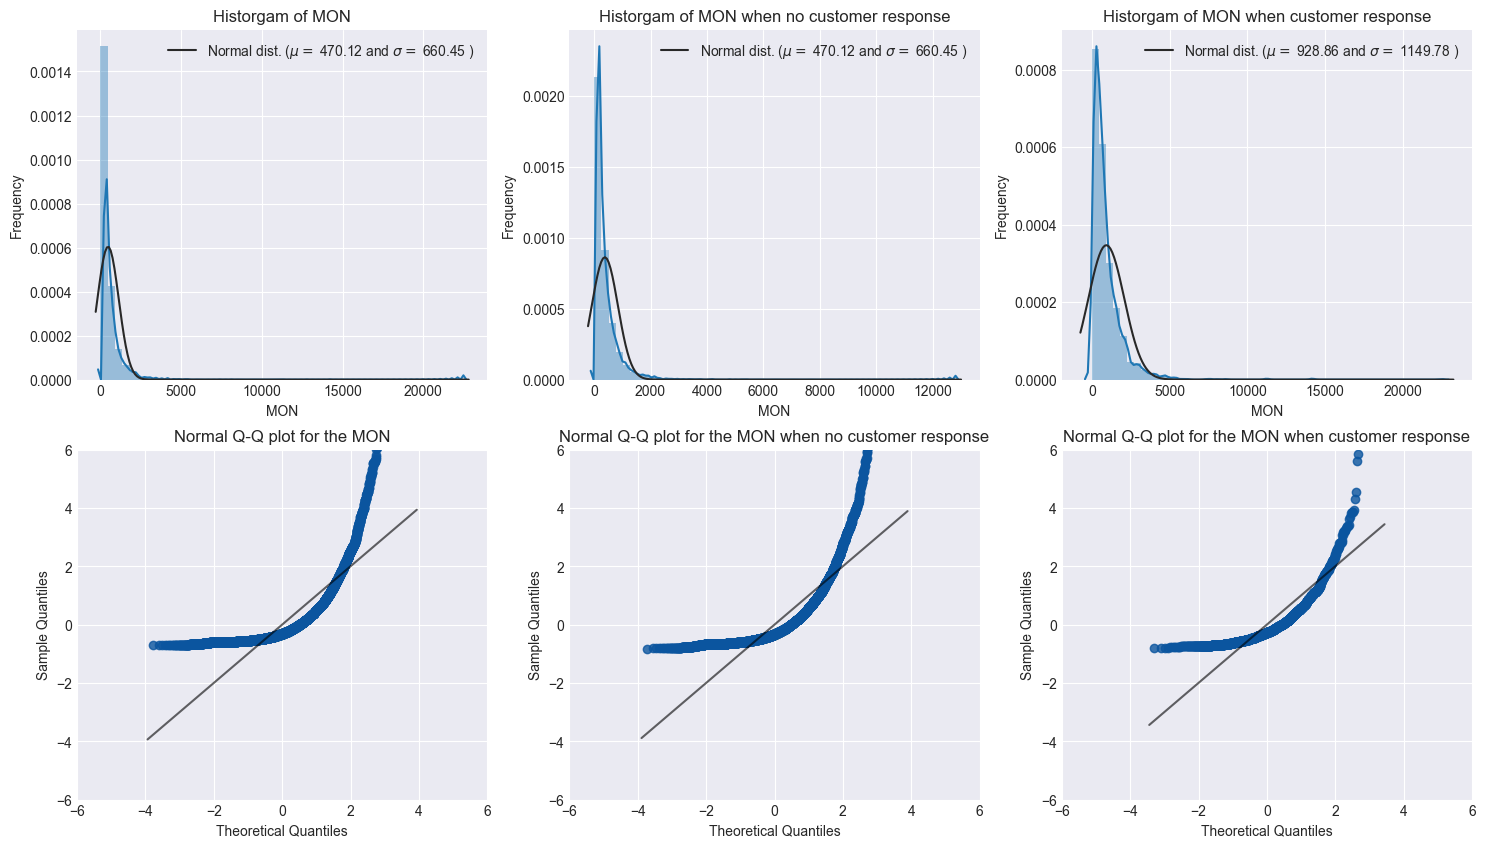

In [52]:
distribution_histor_Q_Qplot("MON", train, train_y0, train_y1)

In [53]:
train['BoxCoxMON']=bonxcox_transf(train['MON'])
train_y0['BoxCoxMON']=bonxcox_transf(train_y0['MON']) 
train_y1['BoxCoxMON']=bonxcox_transf(train_y1['MON'])

The lmbda is: -0.0768095036749
The lmbda is: -0.0647493609027
The lmbda is: 0.0571573188344


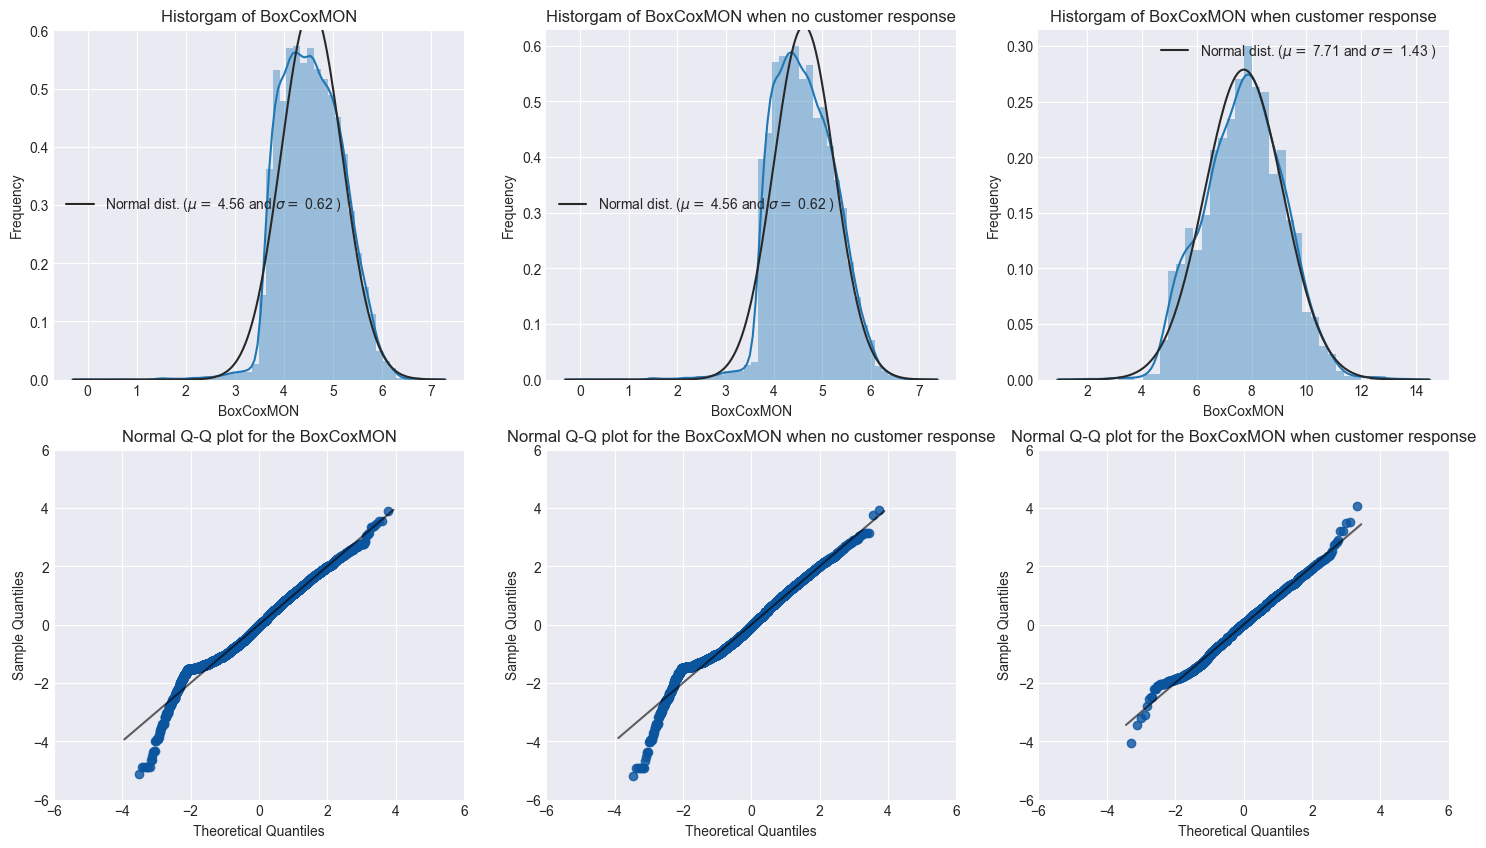

In [54]:
# plot the distribution and the box plot of the responses 
distribution_histor_Q_Qplot("BoxCoxMON", train, train_y0, train_y1) 


Although perfect normality is not obtained, the result is nevertheless much less skewed than the raw data distribution, allowing for smoother application of several data mining methods and models


## REC

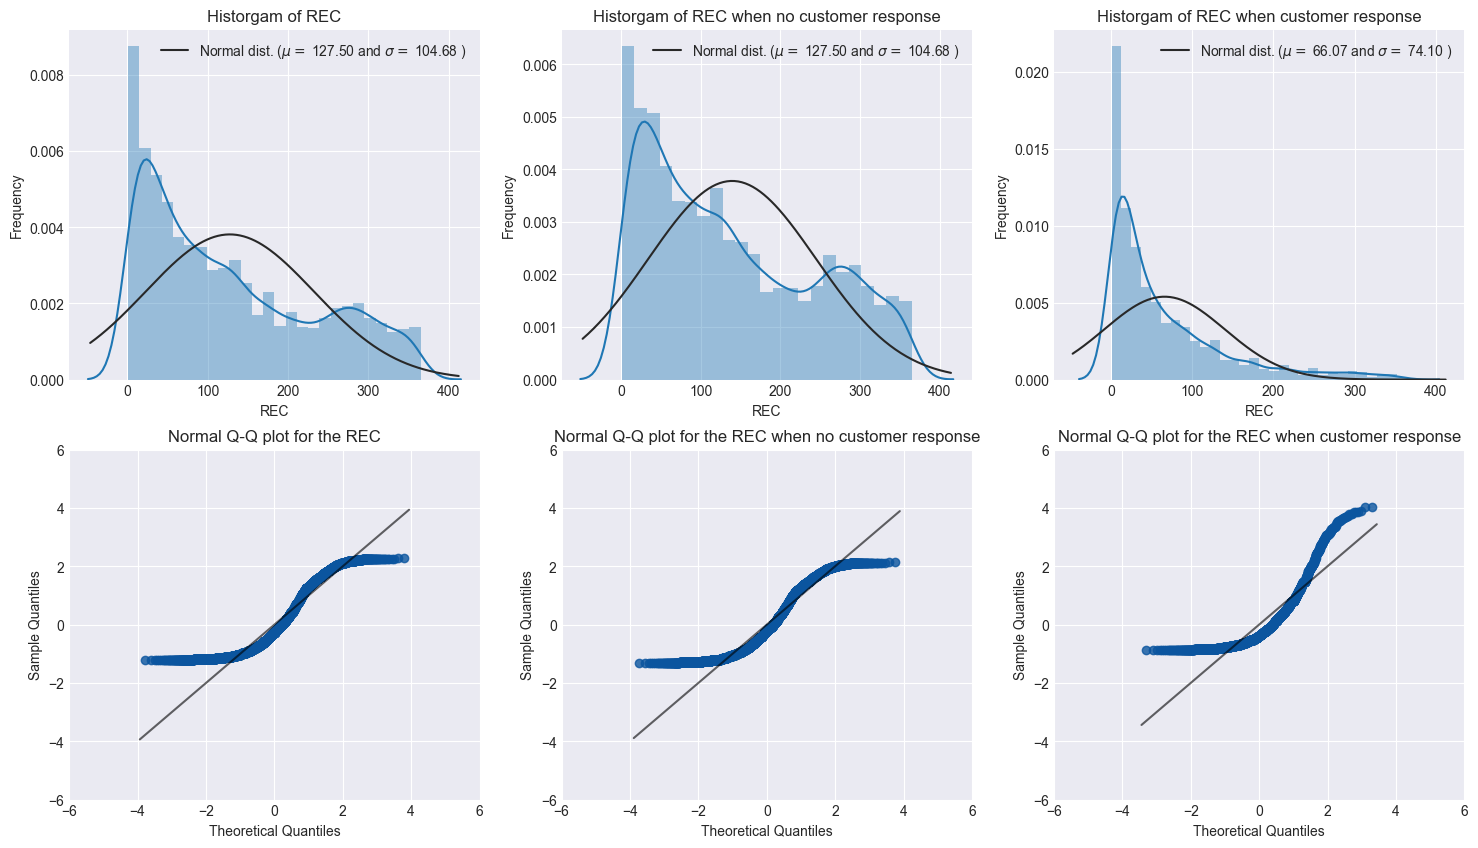

The lmbda is: 0.35314984645
The lmbda is: 0.415397954642
The lmbda is: 0.142510096207
-----------------after boxcox transformation----------


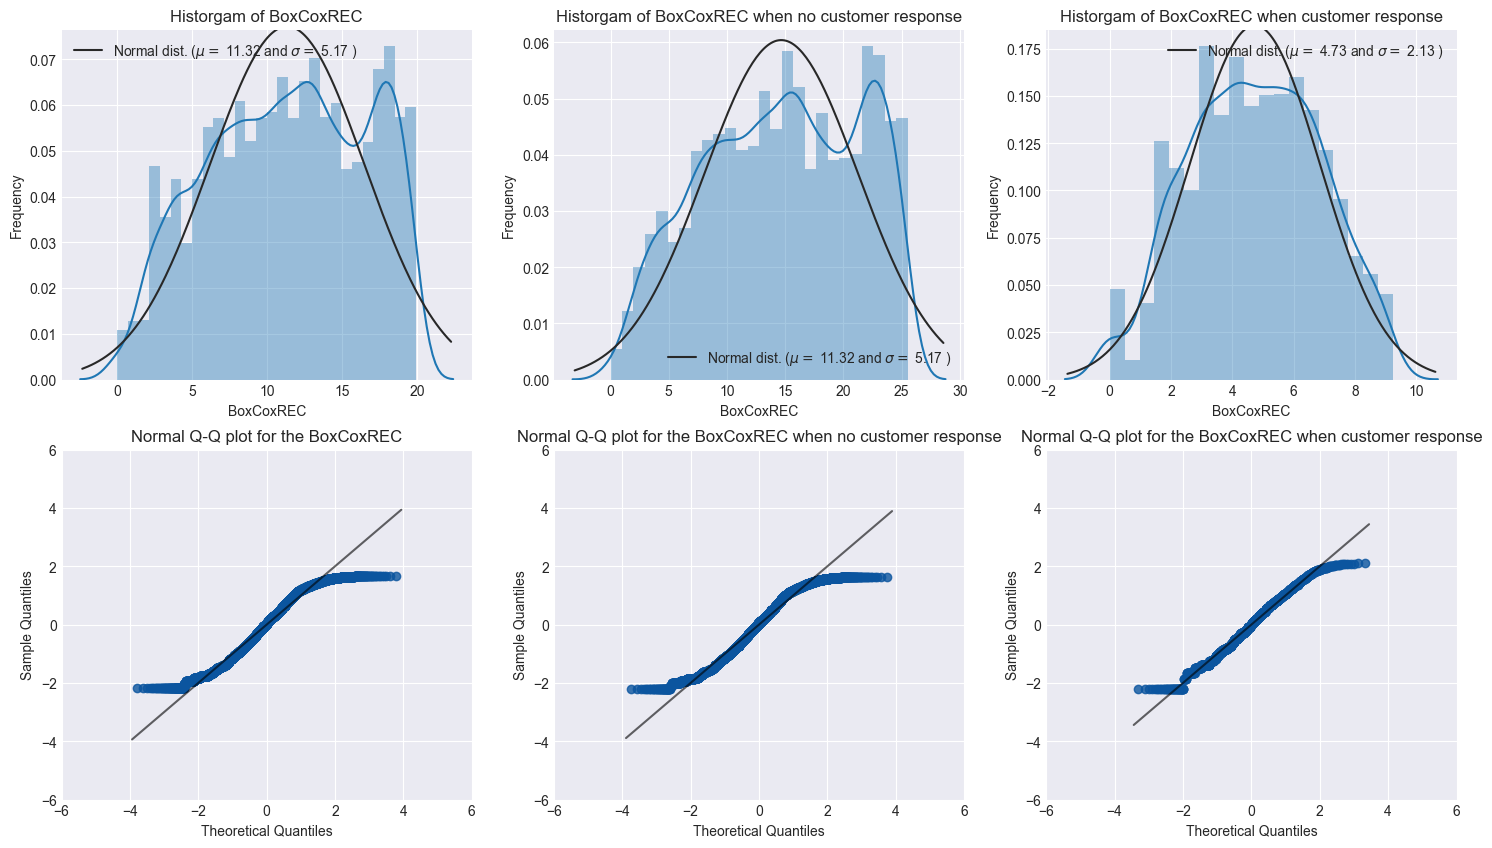

In [55]:
distribution_histor_Q_Qplot("REC", train, train_y0, train_y1)

train['BoxCoxREC']=bonxcox_transf(train['REC'])
train_y0['BoxCoxREC']=bonxcox_transf(train_y0['REC']) 
train_y1['BoxCoxREC']=bonxcox_transf(train_y1['REC'])

print ("-----------------after boxcox transformation----------")

distribution_histor_Q_Qplot("BoxCoxREC", train, train_y0, train_y1) 

## FRE

most variables are 1 and 2

In [56]:
count_o=train.groupby("FRE").count()
print(count_o.loc[:,'RESP'].head(5))   # no 0 values, but most of them are 1,2 and 3.

FRE
1    3459
2    2384
3    1628
4    1152
5     840
Name: RESP, dtype: int64


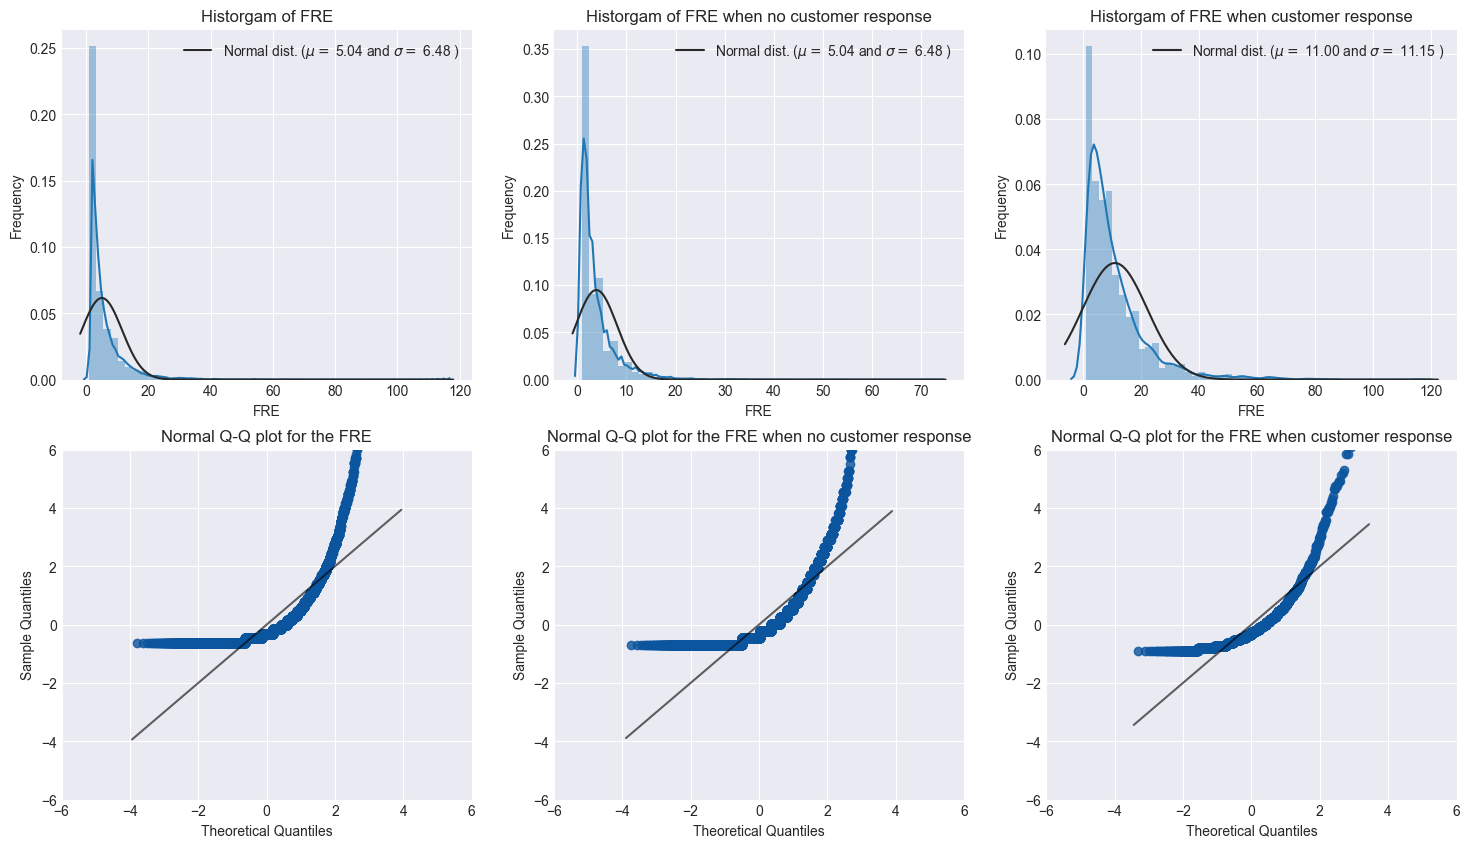

The lmbda is: -0.252589275992
The lmbda is: -0.300637174566
The lmbda is: 0.0611684584375
-----------------after boxcox transformation----------


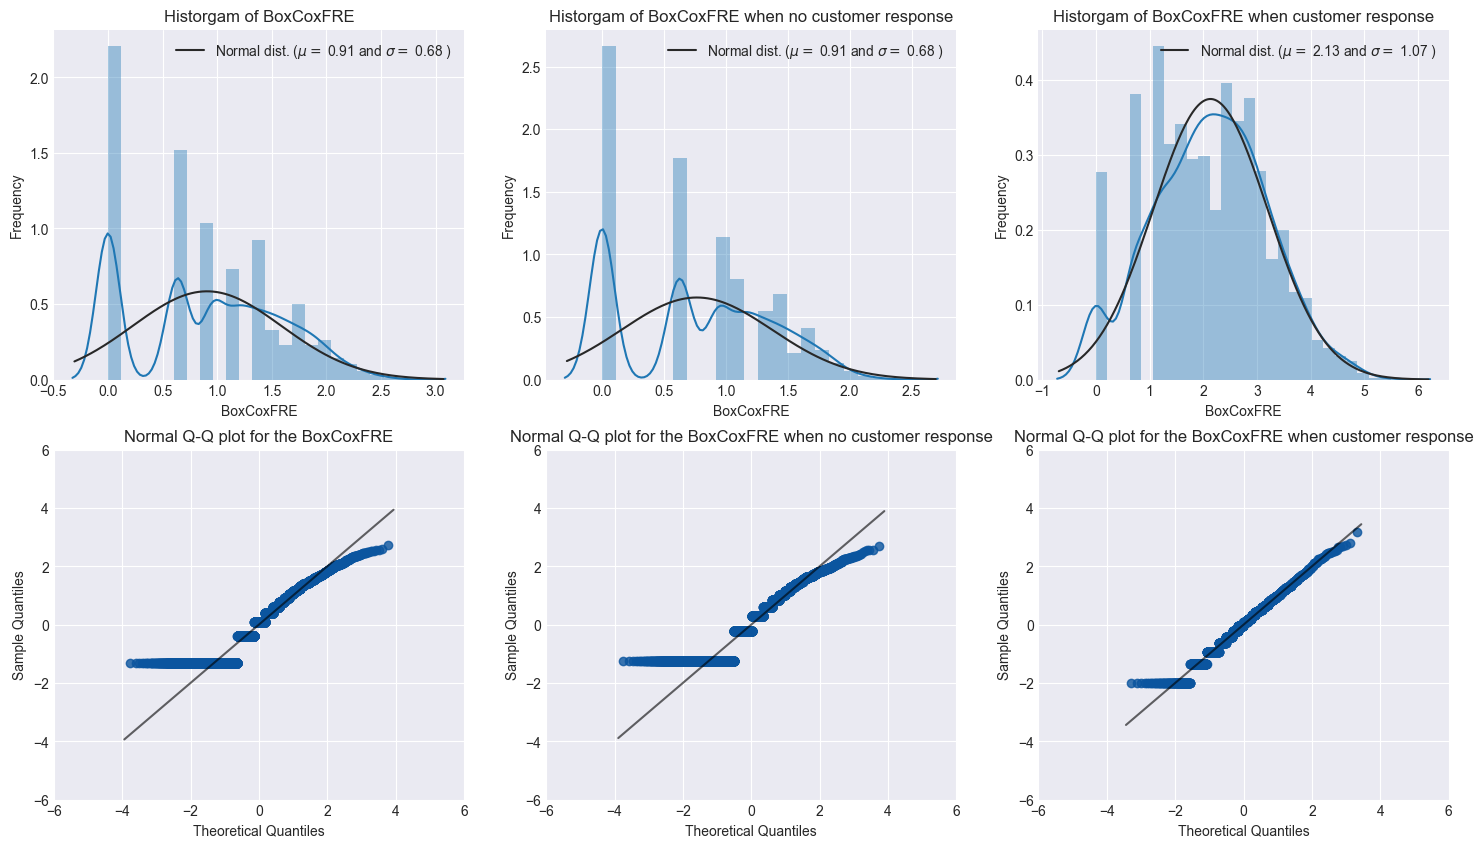

In [57]:
distribution_histor_Q_Qplot("FRE", train, train_y0, train_y1)

train['BoxCoxFRE']=bonxcox_transf(train['FRE'])
train_y0['BoxCoxFRE']=bonxcox_transf(train_y0['FRE']) 
train_y1['BoxCoxFRE']=bonxcox_transf(train_y1['FRE'])

print ("-----------------after boxcox transformation----------")

distribution_histor_Q_Qplot("BoxCoxFRE", train, train_y0, train_y1) 

In [58]:
# as boxcox transf is not good , we try log 
train['LogFRE']=log_transf(train['FRE'])
train_y0['LogFRE']=log_transf(train_y0['FRE']) 
train_y1['LogFRE']=log_transf(train_y1['FRE'])